# Part 3 of Makemore series...

Andrej brings back old code but in a cleaned up fashion here into the notebook. Gonna do the same

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importing all the names 
names = open('names.txt','r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# Prepping the vocab and the vocab lookup table
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We now build the dataset for the NN by splitting into train, val, test, which we had skipped in the previous lecture

In [12]:
context_length = 3

def build_dataset(names):
    X, Y = [], []

    for name in names:
        context = [0] * context_length
        for ch in name + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

train_size = int(0.8 * len(names))
val_size = int(0.9 * len(names))
test_size = len(names)
#randomise the list names
import random
random.shuffle(names)

Xtr, Ytr = build_dataset(names[:train_size])
Xval, Yval = build_dataset(names[train_size:val_size])
Xtest, Ytest = build_dataset(names[val_size:])

torch.Size([182203, 3]) torch.Size([182203])
torch.Size([23009, 3]) torch.Size([23009])
torch.Size([22934, 3]) torch.Size([22934])


In [66]:
# Hyper parameters
embedding_space_size = 10
hidden_layer_size = 200

# Initialisation 
C = torch.randn((vocab_size,embedding_space_size))
W1 = torch.randn([context_length * embedding_space_size,hidden_layer_size]) * 0.2
b1 = torch.randn(hidden_layer_size) * 0.01
W2 = torch.randn([hidden_layer_size, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_()

In [68]:
max_steps = 200000
minibatch_size = 64
lossi = []

for step in range(max_steps):
    # generate minibatch
    minibatch = torch.randint(0, Xtr.shape[0], (minibatch_size,))

    # forward pass
    emb = C[Xtr[minibatch]]
    embcat = emb.view(-1,context_length * embedding_space_size)
    h1preact = embcat @ W1 + b1
    h1 = torch.tanh(h1preact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[minibatch])

    # Backpropagate gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    learning_rate = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if step % 10000 == 0:
        print(f'{step}/{max_steps} : {loss.item():4f}')
    lossi.append(loss.log10().item())
    # break

0/200000 : 3.235729
10000/200000 : 2.123445
20000/200000 : 1.929967
30000/200000 : 2.528100
40000/200000 : 2.114975
50000/200000 : 2.025455
60000/200000 : 2.285210
70000/200000 : 1.990387
80000/200000 : 2.290518
90000/200000 : 2.142181
100000/200000 : 2.209562
110000/200000 : 2.235901
120000/200000 : 2.269677
130000/200000 : 2.035066
140000/200000 : 2.023320
150000/200000 : 2.149818
160000/200000 : 1.838547
170000/200000 : 2.384390
180000/200000 : 1.822061
190000/200000 : 2.154118


In [69]:
h1preact.shape

torch.Size([64, 200])

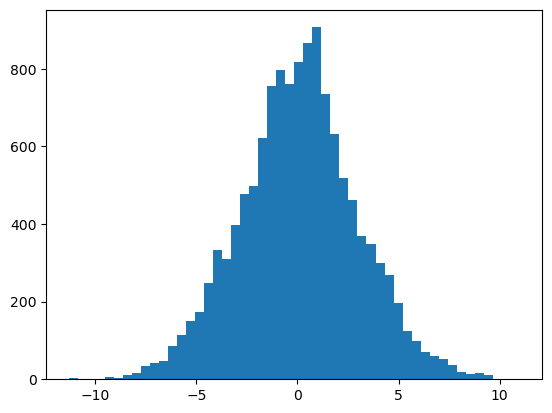

In [70]:
plt.hist(h1preact.view(-1).tolist(),bins=50);

1


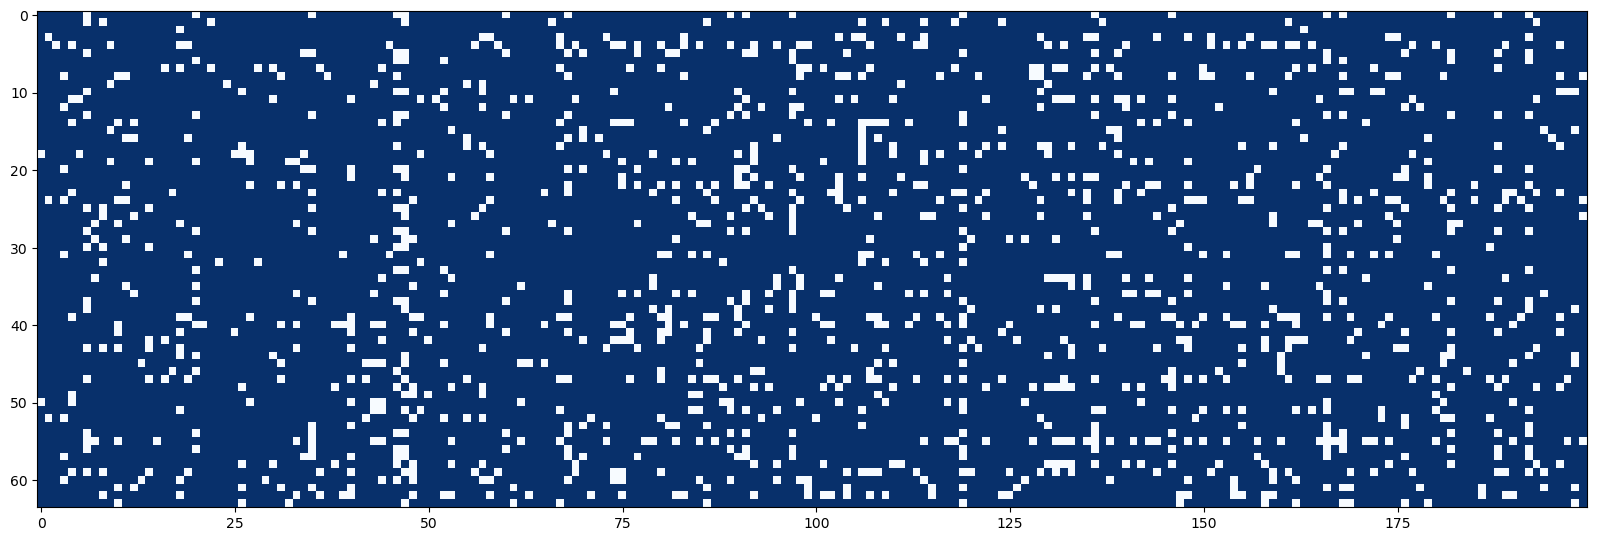

In [65]:
plt.figure(figsize=(20,10))
threshold = 10**0
print(threshold)
plt.imshow((h1.abs() < threshold), cmap='Blues')

In [20]:
logits[0]

tensor([ 18.8208,  17.5400,  13.0905,   7.5304, -18.3885,  -0.6099,   4.3749,
        -24.3906,  -5.9948,  -0.4642,  15.8345,  -4.9034,  18.6507,   4.2461,
         12.5569,   1.6174,  11.8037,  -0.5865,  -9.5721,  11.3786,  -0.3032,
        -15.8605,  15.9714,   7.2187,   5.3640,   5.9847,   6.6094],
       grad_fn=<SelectBackward0>)

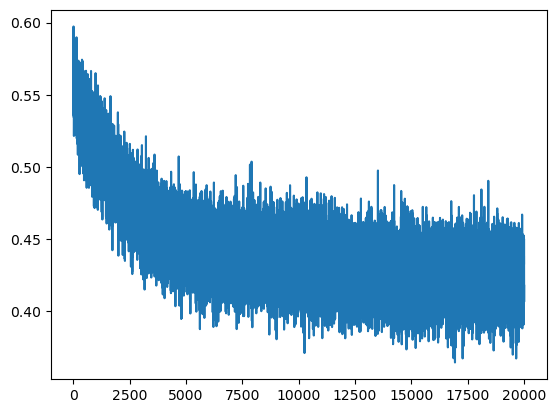

In [15]:
plt.plot(torch.arange(len(lossi)),lossi)

In [36]:
@torch.no_grad()
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 'val': (Xval, Yval), 'test': (Xtest, Ytest)}[split]
    emb = C[x]
    h = torch.tanh(emb.view(-1,context_length * embedding_space_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [35]:
split_loss('train')
split_loss('val')

train 2.116483449935913
val 2.167696237564087


Look up torch context manager

# Torchifying the code

This part of the lecture teaches how to torchify the code by implementing your own version of the different layers that PyTorch ships with

In [109]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5 # This is to have unit normal (Kaiming init)
        self.bias = torch.zeros((fan_out,)) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class batchNorm1d:
    def __init__(self, dim, momentum = 0.1, eps = 10**-5):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters of the layer
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # keeping track of the batch mean and std
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.runnin_var
        xhat = ((x - xmean) / torch.sqrt(xvar + self.eps))
        self.out = self.gamma *  xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_mean + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [116]:
# The way to create your network would be as follows
embedding_space_size = 10
hidden_layer_size = 100

C = torch.randn((27, embedding_space_size))

layers = [
    Linear(embedding_space_size * context_length, hidden_layer_size) , Tanh() , batchNorm1d(hidden_layer_size),
    Linear(                    hidden_layer_size, hidden_layer_size) , Tanh() , batchNorm1d(hidden_layer_size),
    Linear(                    hidden_layer_size, hidden_layer_size) , Tanh() , batchNorm1d(hidden_layer_size),
    Linear(                    hidden_layer_size, hidden_layer_size) , Tanh() , batchNorm1d(hidden_layer_size),
    Linear(                    hidden_layer_size, hidden_layer_size) , Tanh() , batchNorm1d(hidden_layer_size),
    Linear(                    hidden_layer_size, vocab_size)
    ]

with torch.no_grad():
    layers[-1].weights += 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad_()

47497


In [117]:
max_steps = 20000
minibatch_size = 32
lossi = []

for step in range(max_steps):
    # minibatch
    minibatch = torch.randint(Xtr.shape[0], (minibatch_size,))

    # forward pass
    emb = C[Xtr[minibatch]]
    x = emb.view(-1, context_length * embedding_space_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ytr[minibatch])

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update values
    lr = 0.1 if step < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if step % 1000 == 0:
        print(f"{step}/{max_steps}: loss - {loss.item()}")

0/20000: loss - 3.9409663677215576
1000/20000: loss - 2.5203397274017334
2000/20000: loss - 2.5246496200561523
3000/20000: loss - 2.057762861251831
4000/20000: loss - 2.423868179321289
5000/20000: loss - 1.9973846673965454
6000/20000: loss - 2.4183802604675293
7000/20000: loss - 2.0088937282562256
8000/20000: loss - 2.396124839782715
9000/20000: loss - 2.4366917610168457
10000/20000: loss - 2.4993598461151123
11000/20000: loss - 2.0423567295074463
12000/20000: loss - 1.965867042541504
13000/20000: loss - 2.1831142902374268
14000/20000: loss - 2.0754363536834717
15000/20000: loss - 2.3437299728393555
16000/20000: loss - 2.009913921356201
17000/20000: loss - 2.012605667114258
18000/20000: loss - 1.9985017776489258
19000/20000: loss - 1.8406665325164795


In [98]:
torch.randint()

TypeError: randint() received an invalid combination of arguments - got (), but expected one of:
 * (int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [101]:
torch.randint(Xtr.shape[0], (minibatch_size,))

tensor([109353,  27465, 137918, 113921,  30812,   6723, 113645,   4904,  38962,
        133623, 109568, 150858,  77443, 122178, 122746,  42238,  77032, 138526,
         64237, 163652,  97455, 140563, 102146,   8253, 101529,  14312, 140666,
         32676, 117881, 153721,  35980,  75327])